In [2]:
import cv2
import numpy as np
import tifffile as tiff
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from collections import defaultdict
import time

In [3]:
file_path = '../sample_data/crop1_HCAEC_Pg33277_4h.tif'  # Replace with the actual path to your TIFF file
image_stack = tiff.imread(file_path)
# labels=process_image_stack(file_path)

In [38]:
def apply_fourier_transform(image):
    f_transform = np.fft.fft2(image)
    f_shift = np.fft.fftshift(f_transform)
    return f_shift

def apply_inverse_fourier_transform(f_shift):
    f_ishift = np.fft.ifftshift(f_shift)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)
    return img_back

def create_notch_filter(shape, centers, radius):
    rows, cols = shape
    mask = np.ones((rows, cols), np.uint8)
    
    x, y = np.ogrid[:rows, :cols]
    for center in centers:
        crow, ccol = center
        mask_area = (x - crow)**2 + (y - ccol)**2 <= radius**2
        mask[mask_area] = 0
    
    return mask

def process_image(image, notch_centers, notch_radius):
    f_shift = apply_fourier_transform(image)
    
    notch_filter = create_notch_filter(image.shape, notch_centers, notch_radius)
    
    filtered_f_shift = f_shift * notch_filter
    
    filtered_image = apply_inverse_fourier_transform(filtered_f_shift)
    
    return filtered_image

def enhance_image(image, method='scaling', clip_limit=2.0, tile_grid_size=(8, 8), alpha=1.5, beta=50):
    if method == 'histogram_equalization':
        enhanced_image = cv2.equalizeHist(image.astype(np.uint8))
    elif method == 'clahe':
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
        enhanced_image = clahe.apply(image.astype(np.uint8))
    elif method == 'scaling':
        enhanced_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    else:
        raise ValueError("Invalid enhancement method. Choose 'histogram_equalization', 'clahe', or 'scaling'.")
    return enhanced_image

def normalize_intensity_across_stack(image_stack):
    # Calculate global mean and std deviation for the entire stack
    all_pixels = np.concatenate([image.flatten() for image in image_stack])
    global_mean = np.mean(all_pixels)
    global_std = np.std(all_pixels)
    
    # Normalize each image in the stack
    normalized_stack = []
    for image in image_stack:
        image = (image - np.mean(image)) / np.std(image)  # Standardize
        image = image * global_std + global_mean  # Scale to global stats
        image = np.clip(image, 0, 255)  # Clip to valid intensity range
        normalized_stack.append(image.astype(np.uint8))
    
    return np.array(normalized_stack)

def adjust_brightness_contrast(image, brightness=1.0, contrast=1.0):
    # For user-defined visualization
    image=image*brightness
    mean_img = np.mean(image)
    image = (image-mean_img)*contrast+mean_img
    image = np.clip(image,0,255)
    return image.astype(np.uint8)


In [43]:
def process_and_save_tiff(input_path, enhancement_method, alpha, beta=10, output_path=None, colormap="hot"):
    # Load the image stack
    image_stack = tiff.imread(input_path)

    # Define the centers and radius for the notch filters (based on the interference pattern)
    notch_centers = [(image_stack[0].shape[0]//2, image_stack[0].shape[1]//2)]  # Adjust this based on the pattern
    notch_radius = 20  # Adjust this based on the pattern

    # Process and enhance each image in the stack
    processed_stack = []
    for i, original_image in enumerate(image_stack):
        filtered_image = process_image(original_image, notch_centers, notch_radius)
        filtered_image = cv2.normalize(filtered_image, None, 0, 255, cv2.NORM_MINMAX)
        enhanced_image = enhance_image(filtered_image, method=enhancement_method, alpha=alpha, beta=beta)
        processed_stack.append(enhanced_image)

    # Normalize intensity across the entire stack
    normalized_stack = normalize_intensity_across_stack(processed_stack)

    # Save the normalized stack to a new TIFF file
    if output_path:
        tiff.imwrite(output_path, normalized_stack)

    # Optionally, display the images
    fig, axes=plt.subplots(1,3,figsize=(12,4))
    axes[0].imshow(image_stack[0], cmap=colormap)
    axes[0].set_title('First Raw Image')
    
    adjusted_image=adjust_brightness_contrast(image_stack[0], brightness=1.0, contrast=1.0)
    axes[1].imshow(adjusted_image, cmap=colormap)
    axes[1].set_title('First Adjusted Image')

    axes[2].imshow(normalized_stack[0], cmap=colormap)
    axes[2].set_title('First Normalized Enhanced Image')
    for ax in axes:
        ax.axis("off")

    plt.show()

    # plt.imshow(image_stack[0], cmap='hot')
    # plt.title('First Raw Image')
    # plt.axis('off')
    # plt.show()
    # # Optionally, display the first image in the original stack with user-defined adjustment
    # adjusted_image=adjust_brightness_contrast(image_stack[0], brightness=1.0, contrast=1.0)
    # plt.imshow(adjusted_image, cmap='hot')
    # plt.title('First Adjusted Image')
    # plt.axis('off')
    # plt.show()
    # # Optionally, display the first image in the normalized stack
    # plt.imshow(normalized_stack[0], cmap='hot')
    # plt.title('First Normalized Enhanced Image')
    # plt.axis('off')
    # plt.show()



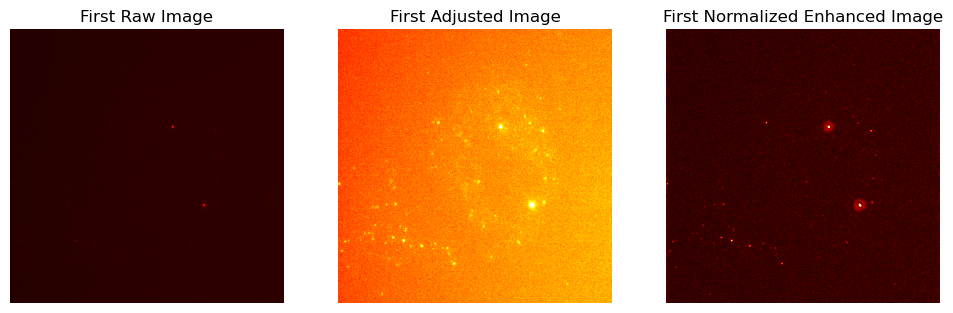

In [49]:
# Example usage
input_file_path = '../sample_data/crop1_HCAEC_Pg33277_4h.tif'
output_file_path = './test_normalized_image_stack.tif'
enhancement_method = 'scaling'
alpha = 10
beta = 10

process_and_save_tiff(input_file_path, enhancement_method, alpha, beta, output_file_path, colormap='hot')


In [12]:
import cv2
import numpy as np
import tifffile as tiff
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import time

# Global variable to store the selected center
selected_center = None

def select_center(event, x, y, flags, param):
    global selected_center
    if event == cv2.EVENT_LBUTTONDOWN:
        selected_center = (x, y)
        print(f"Selected center: {selected_center}")

def load_image_stack(file_path):
    """Load the image stack from a TIFF file."""
    return tiff.imread(file_path)

def display_initial_image(image):
    """Display the initial image and allow the user to select the center."""
    cv2.namedWindow("Select Center")
    cv2.setMouseCallback("Select Center", select_center)
    
    while True:
        cv2.imshow("Select Center", image)
        if cv2.waitKey(1) & 0xFF == 27 or selected_center is not None:  # ESC key to exit
            break
    
    cv2.destroyAllWindows()
    return selected_center

def threshold_image(image, threshold_value=128):
    """Threshold the image to create a binary image."""
    _, binary_image = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY)
    return binary_image

def extract_coordinates(binary_image):
    """Extract coordinates of bright spots from the binary image."""
    coordinates = np.column_stack(np.where(binary_image > 0))
    return coordinates

def apply_dbscan(coordinates, eps=2, min_samples=2):
    """Apply DBSCAN clustering to the coordinates."""
    if len(coordinates) == 0:
        return np.array([]), np.array([])
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(coordinates)
    labels = db.labels_
    # Filter out noise points
    core_coords = coordinates[labels != -1]
    core_labels = labels[labels != -1]
    return core_coords, core_labels

def draw_clusters(image, coordinates, labels, line_thickness=5):
    """Draw clusters on the original image with inverted colors and thicker lines."""
    inverted_image = cv2.bitwise_not(image)  # Invert the image colors
    output_image = cv2.cvtColor(inverted_image, cv2.COLOR_GRAY2RGB)
    unique_labels = set(labels)
    for label in unique_labels:
        if label == -1:
            continue
        class_member_mask = (labels == label)
        xy = coordinates[class_member_mask]
        for point in xy:
            cv2.circle(output_image, (point[1], point[0]), line_thickness, (0, 0, 255), -1)  # Red points
    return output_image

def process_image_stack(file_path, eps=2, min_samples=2, threshold_value=128, output_path=None, line_thickness=5):
    """Process the entire image stack with DBSCAN and save the results."""
    # Load the image stack
    image_stack = load_image_stack(file_path)
    
    # Store DBSCAN coordinates for later use
    dbscan_coords_stack = []
    
    # Process each image in the stack
    result_stack = []
    for i, image in enumerate(image_stack):
        # Threshold the image to get a binary image
        binary_image = threshold_image(image, threshold_value)
        
        # Extract coordinates of potential vesicle positions
        coordinates = extract_coordinates(binary_image)
        
        # Apply DBSCAN to cluster the coordinates
        core_coords, core_labels = apply_dbscan(coordinates, eps, min_samples)
        
        # Store the DBSCAN-processed coordinates
        dbscan_coords_stack.append(core_coords)
        
        # Draw clusters on the original image
        result_image = draw_clusters(image, core_coords, core_labels, line_thickness)
        
        # Add the result image to the result stack
        result_stack.append(result_image)
    
    # Convert the result stack to a NumPy array
    result_stack = np.array(result_stack)
    
    # Save the result stack to a new TIFF file
    if output_path:
        tiff.imwrite(output_path, result_stack)
    
    return dbscan_coords_stack

def cartesian_to_polar(coordinates, center):
    """Convert Cartesian coordinates to polar coordinates."""
    x = coordinates[:, 1] - center[0]
    y = coordinates[:, 0] - center[1]
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    polar_coordinates = np.column_stack((rho, phi))
    return polar_coordinates

def convert_coords_stack_to_polar(dbscan_coords_stack, center, max_r, line_thickness=5):
    """Convert the DBSCAN coordinates in the image stack to polar coordinates."""
    polar_stack = []
    for coords in dbscan_coords_stack:
        polar_image = np.ones((int(max_r), 360, 3), dtype=np.uint8) * 255  # Create a white image with dimensions (max_r, 360, 3)
        if coords.size > 0:
            polar_coordinates = cartesian_to_polar(coords, center)
            rho = polar_coordinates[:, 0]
            phi = np.degrees(polar_coordinates[:, 1]) + 180  # Convert radians to degrees and shift to 0-360
            rho = np.clip(rho, 0, max_r - 1).astype(int)
            phi = np.clip(phi, 0, 359).astype(int)
            for r, p in zip(rho, phi):
                cv2.circle(polar_image, (p, r), line_thickness, (255, 0, 0), -1)  # Draw thicker red points
        polar_stack.append(polar_image)
    return np.array(polar_stack)

def save_image_stack(file_path, image_stack):
    """Save the image stack to a TIFF file."""
    tiff.imwrite(file_path, image_stack)

# Example usage for DBSCAN processing
file_path = './normalized_image_stack.tif'  # Replace with the actual path to your TIFF file
output_path = './result_image_stack_filtered.tif'  # Replace with the desired output path
eps = 2  # Adjust based on expected vesicle size
min_samples = 2  # Adjust based on expected density of vesicle clusters
threshold_value = 128  # Adjust based on intensity threshold for vesicle detection
line_thickness = 5  # Thickness of the line used to label the detected vesicles

dbscan_coords_stack = process_image_stack(file_path, eps, min_samples, threshold_value, output_path, line_thickness)

# Main script for polar conversion
polar_image_path = './polar_converted_stack.tif'  # Output path for polar converted images

# Display the first image to select the center
initial_image = tiff.imread(file_path)[0]
center = display_initial_image(initial_image)

# Measure the time taken for the conversion
start_time = time.time()

# Determine the maximum radius based on the image dimensions
max_r = np.sqrt(initial_image.shape[0]**2 + initial_image.shape[1]**2)

# Convert the coordinates stack to polar coordinates based on the selected center
polar_stack = convert_coords_stack_to_polar(dbscan_coords_stack, center, max_r, line_thickness)

# Measure the end time
end_time = time.time()
total_time = end_time - start_time

# Save the polar-converted image stack
save_image_stack(polar_image_path, np.array(polar_stack))

print(f"Polar converted image stack saved to {polar_image_path}")
# print(f"Total processing time: {total_time:.2f} seconds")

# # Estimate the average time per frame
# average_time_per_frame = total_time / len(polar_stack)
# print(f"Average time per frame: {average_time_per_frame:.2f} seconds")


Selected center: (636, 578)
Polar converted image stack saved to ./polar_converted_stack.tif
Total processing time: 0.07 seconds
Average time per frame: 0.00 seconds


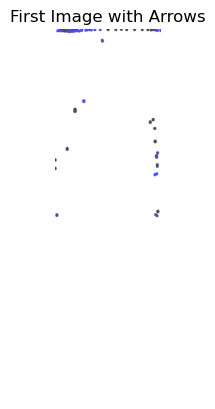

In [23]:
import cv2
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt

def calculate_optical_flow(prev_img, next_img, threshold):
    """Calculate the optical flow between two images."""
    if len(prev_img.shape) == 3:
        prev_img = cv2.cvtColor(prev_img, cv2.COLOR_RGB2GRAY)
    if len(next_img.shape) == 3:
        next_img = cv2.cvtColor(next_img, cv2.COLOR_RGB2GRAY)
    
    flow = cv2.calcOpticalFlowFarneback(prev_img, next_img, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    return flow

def draw_arrows(image, flow, threshold, line_thickness=2, arrow_scale=10, tip_length=0.5, color=(0, 0, 255)):
    """Draw arrows on the image based on the optical flow."""
    h, w = image.shape[:2]
    mask = np.zeros_like(image)
    if len(image.shape) == 2:
        mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    
    for y in range(0, h, 5):  # Increase arrow density
        for x in range(0, w, 5):  # Increase arrow density
            fx, fy = flow[y, x]
            if np.sqrt(fx**2 + fy**2) > threshold:
                end_x = int(x + fx * arrow_scale)  # Scale the arrow length
                end_y = int(y + fy * arrow_scale)  # Scale the arrow length
                cv2.arrowedLine(mask, (x, y), (end_x, end_y), color, line_thickness, tipLength=tip_length)
    return mask

# def save_image_stack(file_path, image_stack):
#     """Save the image stack to a TIFF file."""
#     tiff.imwrite(file_path, image_stack)

# Load the polar-converted image stack
polar_image_path = './polar_converted_stack.tif'
polar_stack = tiff.imread(polar_image_path)

# Parameters
threshold = 1  # Movement threshold in pixels (reduced to show more arrows)
line_thickness = 2  # Thickness of the arrow lines
arrow_scale = 10  # Increased scale factor for arrow length
tip_length = 0.5  # Increased length of the arrow tip
color = (0, 0, 255)  # Color of the arrows (blue)

# Process the stack to draw arrows
annotated_stack = []
for i in range(len(polar_stack) - 1):
    prev_img = polar_stack[i]
    next_img = polar_stack[i + 1]
    
    # Ensure both images are grayscale and have the same size
    if len(prev_img.shape) == 3:
        prev_img = cv2.cvtColor(prev_img, cv2.COLOR_RGB2GRAY)
    if len(next_img.shape) == 3:
        next_img = cv2.cvtColor(next_img, cv2.COLOR_RGB2GRAY)
    if prev_img.shape != next_img.shape:
        next_img = cv2.resize(next_img, (prev_img.shape[1], prev_img.shape[0]))
    
    flow = calculate_optical_flow(prev_img, next_img, threshold)
    arrows = draw_arrows(next_img, flow, threshold, line_thickness, arrow_scale, tip_length, color)
    annotated_img = cv2.addWeighted(cv2.cvtColor(next_img, cv2.COLOR_GRAY2RGB), 1, arrows, 1, 0)
    annotated_stack.append(annotated_img)

# Add the last image without arrows
last_img = polar_stack[-1]
if len(last_img.shape) == 2:  # Convert to RGB if needed
    last_img = cv2.cvtColor(last_img, cv2.COLOR_GRAY2RGB)
annotated_stack.append(last_img)

# Save the annotated stack to a new TIFF file
annotated_image_path = './polar_converted_stack_with_arrows.tif'
save_image_stack(annotated_image_path, np.array(annotated_stack))

# Optionally, display the first image with arrows for verification
plt.imshow(annotated_stack[0])
plt.title('First Image with Arrows')
plt.axis('off')
plt.show()


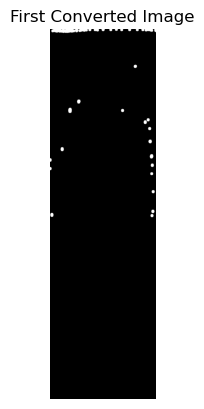

In [34]:
import cv2
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt

def convert_to_white_spots_on_black(image):
    """Convert an image with red spots on white background to white spots on black background."""
    # Ensure the image is in RGB format
    if len(image.shape) == 2:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    else:
        image_rgb = image

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    
    # Invert the grayscale image to get white spots on black background
    inverted_image = cv2.bitwise_not(gray_image)
    
    return inverted_image

# Load the polar-converted image stack
polar_image_path = './polar_converted_stack.tif'
polar_stack = load_image_stack(polar_image_path)

# Process each image in the stack
converted_stack = []
for image in polar_stack:
    converted_image = convert_to_white_spots_on_black(image)
    converted_stack.append(converted_image)

# Save the converted stack to a new TIFF file
output_path = './polar_converted_stack_white_spots_on_black.tif'
tiff.imwrite(output_path, np.array(converted_stack))

# Display the first converted image for verification
plt.imshow(converted_stack[0], cmap='gray')
plt.title('First Converted Image')
plt.axis('off')
plt.show()


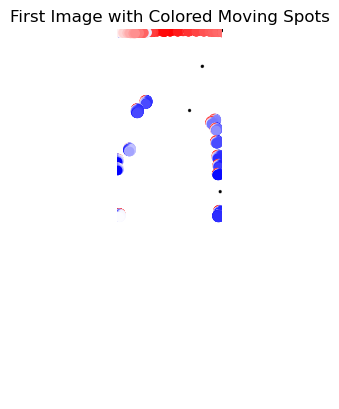

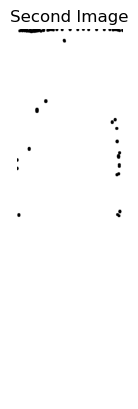

In [42]:
import cv2
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm

def extract_spot_locations(image, threshold_value=128):
    """Extract coordinates of spots from the binary image."""
    _, binary_image = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY)
    coordinates = np.column_stack(np.where(binary_image > 0))
    return coordinates

def find_moving_spots_with_vectors(coords1, coords2, window_size=5):
    """Find spots in coords1 that have corresponding spots in coords2 within the window size and calculate their movement vectors."""
    moving_spots = []
    vectors = []
    for (y1, x1) in coords1:
        for (y2, x2) in coords2:
            if abs(y1 - y2) <= window_size and abs(x1 - x2) <= window_size:
                moving_spots.append((y1, x1))
                vectors.append((y2 - y1, x2 - x1))
                break
    return np.array(moving_spots), np.array(vectors)

def calculate_angles_and_color(moving_spots, vectors, origin, colormap='bwr'):
    """Calculate the angles between the movement vectors and the vectors from the origin and apply colormap."""
    colors = []
    for i, (spot, vector) in enumerate(zip(moving_spots, vectors)):
        vector1 = np.array([spot[0] - origin[0], spot[1] - origin[1]])
        vector2 = vector
        norm1 = np.linalg.norm(vector1)
        norm2 = np.linalg.norm(vector2)
        
        if norm1 == 0 or norm2 == 0:
            angle = 90  # Default to 90 degrees if either vector is zero to indicate no movement
        else:
            angle = np.degrees(np.arccos(np.dot(vector1, vector2) / (norm1 * norm2)))
        
        # Normalize the angle to the range [0, 180]
        angle = min(angle, 180 - angle)
        
        # Determine the color based on the angle
        if angle < 90:
            color = angle / 90  # Scale to [0, 1]
        else:
            color = (angle - 90) / 90  # Scale to [0, 1]
        
        colors.append(color)
    
    norm = Normalize(vmin=0, vmax=1)
    cmap = cm.get_cmap(colormap)
    colored_spots = [cmap(norm(color)) for color in colors]
    
    return colored_spots

# Load the polar-converted image stack
polar_image_path = './polar_converted_stack_white_spots_on_black.tif'
polar_stack = load_image_stack(polar_image_path)

# Define the origin in the polar coordinate system
origin = (180, 1)

# Ensure we have at least two images in the stack
if len(polar_stack) < 2:
    print("The image stack does not contain enough images.")
else:
    first_image = polar_stack[0]
    second_image = polar_stack[1]
    
    # Invert the images to make the background white and spots black
    first_image_inverted = cv2.bitwise_not(first_image)
    second_image_inverted = cv2.bitwise_not(second_image)
    
    # Extract spot locations from both images
    coords1 = extract_spot_locations(first_image)
    coords2 = extract_spot_locations(second_image)
    
    # Find moving spots and their movement vectors
    window_size = 5  # Define the window size
    moving_spots, vectors = find_moving_spots_with_vectors(coords1, coords2, window_size)
    
    # Calculate angles and determine colors
    colored_spots = calculate_angles_and_color(moving_spots, vectors, origin)
    
    # Display the first image with moving spots colored based on their movement direction
    plt.imshow(first_image_inverted, cmap='gray')
    for (spot, color) in zip(moving_spots, colored_spots):
        plt.scatter(spot[1], spot[0], color=color, s=50, edgecolors='none')  # Increase spot size and remove edges
    plt.title('First Image with Colored Moving Spots')
    plt.axis('off')
    plt.show()
    
    # Display the second image for reference
    plt.imshow(second_image_inverted, cmap='gray')
    plt.title('Second Image')
    plt.axis('off')
    plt.show()


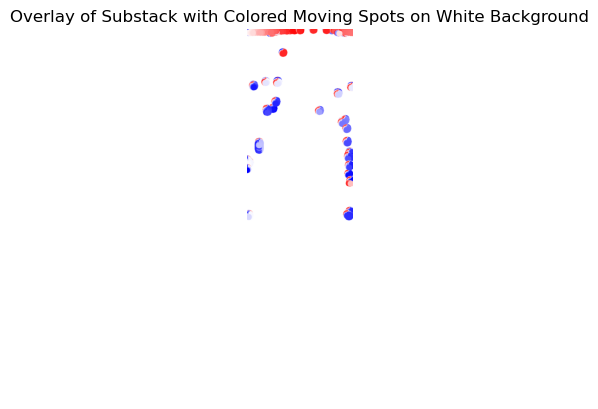

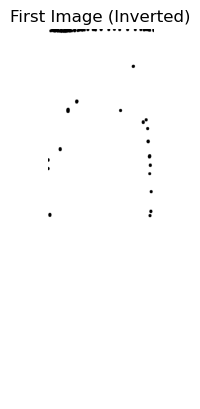

In [48]:
import cv2
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm

def extract_spot_locations(image, threshold_value=128):
    """Extract coordinates of spots from the binary image."""
    _, binary_image = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY)
    coordinates = np.column_stack(np.where(binary_image > 0))
    return coordinates

def find_moving_spots_with_vectors(coords1, coords2, window_size=5):
    """Find spots in coords1 that have corresponding spots in coords2 within the window size and calculate their movement vectors."""
    moving_spots = []
    vectors = []
    for (y1, x1) in coords1:
        for (y2, x2) in coords2:
            if abs(y1 - y2) <= window_size and abs(x1 - x2) <= window_size:
                moving_spots.append((y1, x1))
                vectors.append((y2 - y1, x2 - x1))
                break
    return np.array(moving_spots), np.array(vectors)

def calculate_angles_and_color(moving_spots, vectors, origin, colormap='bwr'):
    """Calculate the angles between the movement vectors and the vectors from the origin and apply colormap."""
    colors = []
    for i, (spot, vector) in enumerate(zip(moving_spots, vectors)):
        vector1 = np.array([spot[0] - origin[0], spot[1] - origin[1]])
        vector2 = vector
        norm1 = np.linalg.norm(vector1)
        norm2 = np.linalg.norm(vector2)
        
        if norm1 == 0 or norm2 == 0:
            angle = 90  # Default to 90 degrees if either vector is zero to indicate no movement
        else:
            angle = np.degrees(np.arccos(np.dot(vector1, vector2) / (norm1 * norm2)))
        
        # Normalize the angle to the range [0, 180]
        angle = min(angle, 180 - angle)
        
        # Determine the color based on the angle
        if angle < 90:
            color = angle / 90  # Scale to [0, 1]
        else:
            color = (angle - 90) / 90  # Scale to [0, 1]
        
        colors.append(color)
    
    norm = Normalize(vmin=0, vmax=1)
    cmap = cm.get_cmap(colormap)
    colored_spots = [cmap(norm(color)) for color in colors]
    
    return colored_spots

# Load the polar-converted image stack
polar_image_path = './polar_converted_stack_white_spots_on_black.tif'
polar_stack = load_image_stack(polar_image_path)

# Define the origin in the polar coordinate system
origin = (180, 1)

# Initialize an image to hold the overlay
overlay_image = np.ones((polar_stack.shape[1], polar_stack.shape[2], 3), dtype=np.float32)  # Initialize with white background

# Process each pair of consecutive images from 1st to 5th images in the stack
for i in range(30,40):
    first_image = polar_stack[i]
    second_image = polar_stack[i + 1]
    
    # Invert the images to make the background white and spots black
    first_image_inverted = cv2.bitwise_not(first_image)
    second_image_inverted = cv2.bitwise_not(second_image)
    
    # Extract spot locations from both images
    coords1 = extract_spot_locations(first_image)
    coords2 = extract_spot_locations(second_image)
    
    # Find moving spots and their movement vectors
    window_size = 5  # Define the window size
    moving_spots, vectors = find_moving_spots_with_vectors(coords1, coords2, window_size)
    
    # Calculate angles and determine colors
    colored_spots = calculate_angles_and_color(moving_spots, vectors, origin)
    
    # Overlay the moving spots on the cumulative image
    for (spot, color) in zip(moving_spots, colored_spots):
        overlay_image = cv2.circle(overlay_image, (spot[1], spot[0]), 10, color, -1)

# Display the overlay image
plt.imshow(overlay_image)
plt.title('Overlay of Substack with Colored Moving Spots on White Background')
plt.axis('off')
plt.show()

# Save the overlay image
output_path = './overlay_colored_moving_spots_substack_white_bg.tif'
tiff.imwrite(output_path, (overlay_image * 255).astype(np.uint8))

# Display the first image as representative
plt.imshow(cv2.bitwise_not(polar_stack[0]), cmap='gray')
plt.title('First Image (Inverted)')
plt.axis('off')
plt.show()


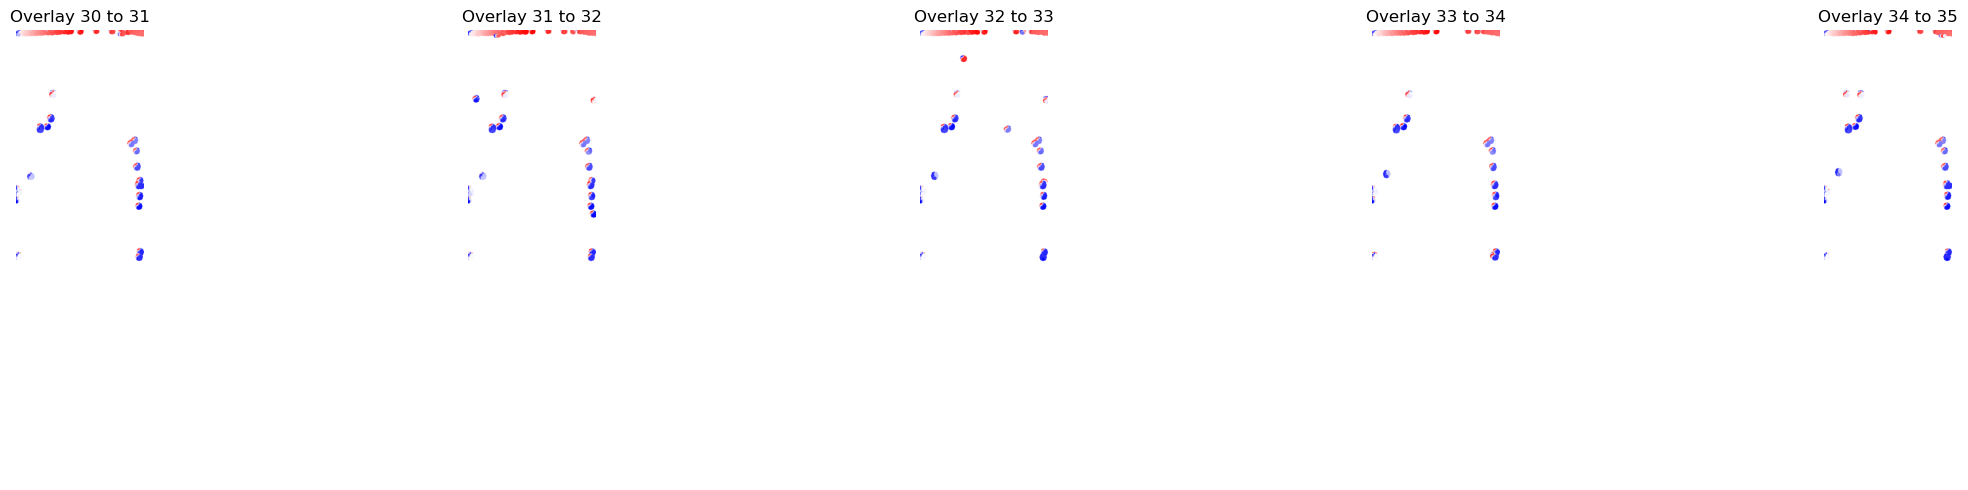

In [54]:
import cv2
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm

def extract_spot_locations(image, threshold_value=128):
    """Extract coordinates of spots from the binary image."""
    _, binary_image = cv2.threshold(image, threshold_value, 255, cv2.THRESH_BINARY)
    coordinates = np.column_stack(np.where(binary_image > 0))
    return coordinates

def find_moving_spots_with_vectors(coords1, coords2, window_size=5):
    """Find spots in coords1 that have corresponding spots in coords2 within the window size and calculate their movement vectors."""
    moving_spots = []
    vectors = []
    for (y1, x1) in coords1:
        for (y2, x2) in coords2:
            if abs(y1 - y2) <= window_size and abs(x1 - x2) <= window_size:
                moving_spots.append((y1, x1))
                vectors.append((y2 - y1, x2 - x1))
                break
    return np.array(moving_spots), np.array(vectors)

def calculate_angles_and_color(moving_spots, vectors, origin, colormap='bwr'):
    """Calculate the angles between the movement vectors and the vectors from the origin and apply colormap."""
    colors = []
    for i, (spot, vector) in enumerate(zip(moving_spots, vectors)):
        vector1 = np.array([spot[0] - origin[0], spot[1] - origin[1]])
        vector2 = vector
        norm1 = np.linalg.norm(vector1)
        norm2 = np.linalg.norm(vector2)
        
        if norm1 == 0 or norm2 == 0:
            angle = 90  # Default to 90 degrees if either vector is zero to indicate no movement
        else:
            angle = np.degrees(np.arccos(np.dot(vector1, vector2) / (norm1 * norm2)))
        
        # Normalize the angle to the range [0, 180]
        angle = min(angle, 180 - angle)
        
        # Determine the color based on the angle
        if angle < 90:
            color = angle / 90  # Scale to [0, 1]
        else:
            color = (angle - 90) / 90  # Scale to [0, 1]
        
        colors.append(color)
    
    norm = Normalize(vmin=0, vmax=1)
    cmap = cm.get_cmap(colormap)
    colored_spots = [cmap(norm(color)) for color in colors]
    
    return colored_spots

# Load the polar-converted image stack
polar_image_path = './polar_converted_stack_white_spots_on_black.tif'
polar_stack = load_image_stack(polar_image_path)

# Define the origin in the polar coordinate system
origin = (180, 1)

# Create subplots
fig, axes = plt.subplots(1, 5, figsize=(25, 5))  # 1 row, 5 columns

# Process each pair of consecutive images from 30th to 35th images in the stack
for i, ax in zip(range(29, 34), axes):
    first_image = polar_stack[i]
    second_image = polar_stack[i + 1]
    
    # Invert the images to make the background white and spots black
    first_image_inverted = cv2.bitwise_not(first_image)
    second_image_inverted = cv2.bitwise_not(second_image)
    
    # Extract spot locations from both images
    coords1 = extract_spot_locations(first_image)
    coords2 = extract_spot_locations(second_image)
    
    # Find moving spots and their movement vectors
    window_size = 5  # Define the window size
    moving_spots, vectors = find_moving_spots_with_vectors(coords1, coords2, window_size)
    
    # Calculate angles and determine colors
    colored_spots = calculate_angles_and_color(moving_spots, vectors, origin)
    
    # Create an image to display
    overlay_image = np.ones((polar_stack.shape[1], polar_stack.shape[2], 3), dtype=np.float32)  # Initialize with white background
    for (spot, color) in zip(moving_spots, colored_spots):
        cv2.circle(overlay_image, (spot[1], spot[0]), 5, color, -1)
    
    # Display the overlay image
    ax.imshow(overlay_image)
    ax.set_title(f'Overlay {i+1} to {i+2}')
    ax.axis('off')

# Adjust layout to reduce space between plots
plt.tight_layout()
# plt.subplots_adjust(wspace=0.01, hspace=0.1)
plt.show()


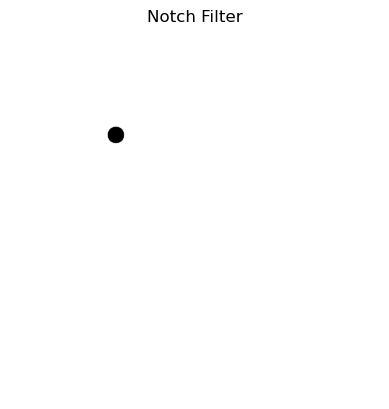

In [18]:
# Example usage
image_shape = (512, 512)
notch_centers = [(image_shape[0]//2, image_shape[1]//2)]
notch_radius = 20
notch_filter = create_notch_filter(image_stack[0].shape, notch_centers, notch_radius)

plt.imshow(notch_filter, cmap='gray')
plt.title('Notch Filter')
plt.axis('off')
plt.show()

In [17]:
image_stack[0].shape

(896, 896)

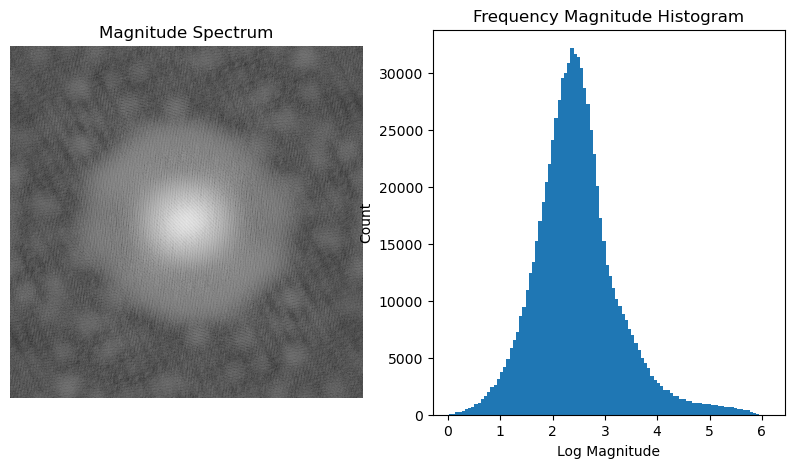

In [19]:
def plot_frequency_spectrum(image):
    f_transform = np.fft.fft2(image)
    f_shift = np.fft.fftshift(f_transform)
    magnitude_spectrum = 20 * np.log(np.abs(f_shift) + 1)  # Log scale for better visibility
    
    plt.figure(figsize=(10, 5))
    
    # Plot the magnitude spectrum
    plt.subplot(1, 2, 1)
    plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title('Magnitude Spectrum')
    plt.axis('off')
    
    # Plot the histogram of frequency magnitudes
    plt.subplot(1, 2, 2)
    plt.hist(np.log(np.abs(f_shift).flatten() + 1), bins=100)
    plt.title('Frequency Magnitude Histogram')
    plt.xlabel('Log Magnitude')
    plt.ylabel('Count')
    
    plt.show()

# Example usage
image = cv2.imread('../sample_data/crop1_HCAEC_Pg33277_4h.tif', cv2.IMREAD_GRAYSCALE)  # Replace with your image path
plot_frequency_spectrum(image)


In [15]:
def apply_dbscan(data, eps=10, min_samples=5):
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(data)
    labels = db.labels_
    return labels


In [16]:
def plot_clusters(image, data, labels):
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    
    plt.imshow(image, cmap='gray')
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = [0, 0, 0, 1]  # Black used for noise.
        
        class_member_mask = (labels == k)
        xy = data[class_member_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)
    
    plt.show()

In [17]:
def process_image_stack(file_path):
    # Load the TIFF stack
    image_stack = tiff.imread(file_path)
    
    # Preprocess each image in the stack
    preprocessed_stack = [preprocess_image(image) for image in image_stack]
    
    # Detect vesicle locations in each preprocessed image
    vesicle_locations_stack = [detect_vesicles(image) for image in preprocessed_stack]

    # Concatenate all vesicle locations from the stack
    all_vesicle_locations = np.concatenate(vesicle_locations_stack)
    
    # Apply DBSCAN to cluster the vesicle locations
    labels = apply_dbscan(all_vesicle_locations)
    
    # Keep track of the start and end indices for each image's vesicle locations
    start_idx = 0
    for image, vesicle_locations in zip(preprocessed_stack, vesicle_locations_stack):
        end_idx = start_idx + len(vesicle_locations)
        plot_clusters(image, vesicle_locations, labels[start_idx:end_idx])
        start_idx = end_idx
    
    return labels
